In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from IPython.display import Image
import graphviz

In [2]:
df = pd.read_csv("../Data/processed_data/all_final_for_model.csv")
X, y = df.drop(['fare_to_predict'], axis=1), df.fare_to_predict

In [3]:
test_indices = json.load(open("../Data/precomputes/test_indices.json"))
X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
X_train, y_train = X.drop(test_indices), y.drop(test_indices)

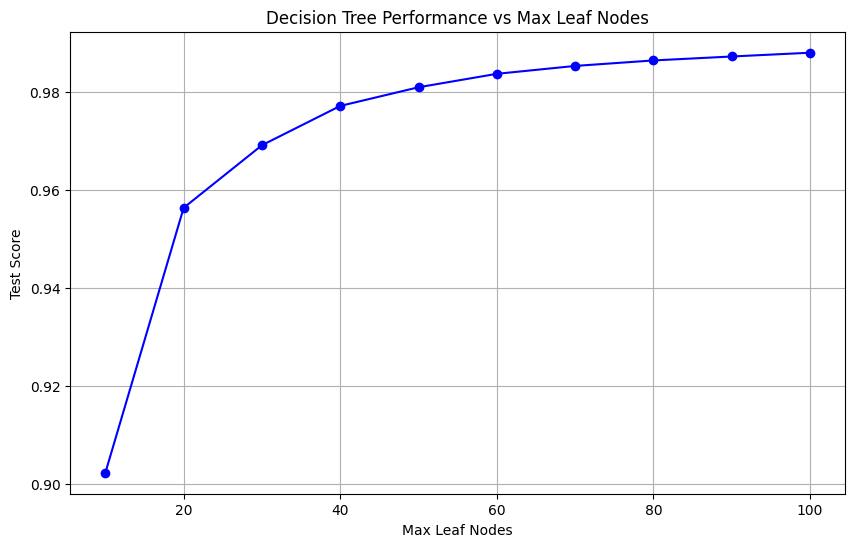

In [37]:
max_leaf_nodes = list(range(10, 101, 10))
dt_models = []
test_scores = []
for leaf_nodes in max_leaf_nodes:
    model = DecisionTreeRegressor(max_leaf_nodes=leaf_nodes)
    model.fit(X_train, y_train)
    dt_models.append(model)
    test_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(max_leaf_nodes, test_scores, marker='o', linestyle='-', color='b')
plt.title('Decision Tree Performance vs Max Leaf Nodes')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Test Score')
plt.grid(True)

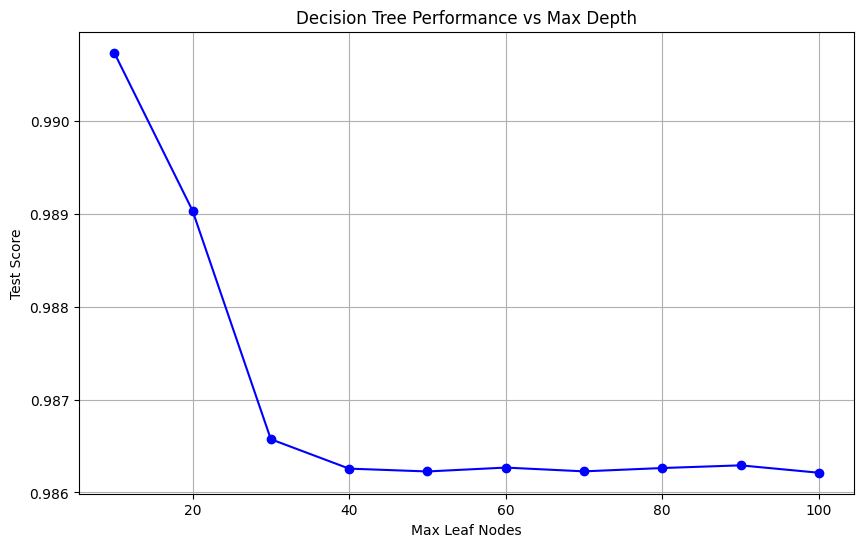

In [38]:
max_depth = list(range(10, 101, 10))
dt_models = []
test_scores = []
for depth in max_depth:
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    dt_models.append(model)
    test_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(max_depth, test_scores, marker='o', linestyle='-', color='b')
plt.title('Decision Tree Performance vs Max Depth')
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Test Score')
plt.grid(True)

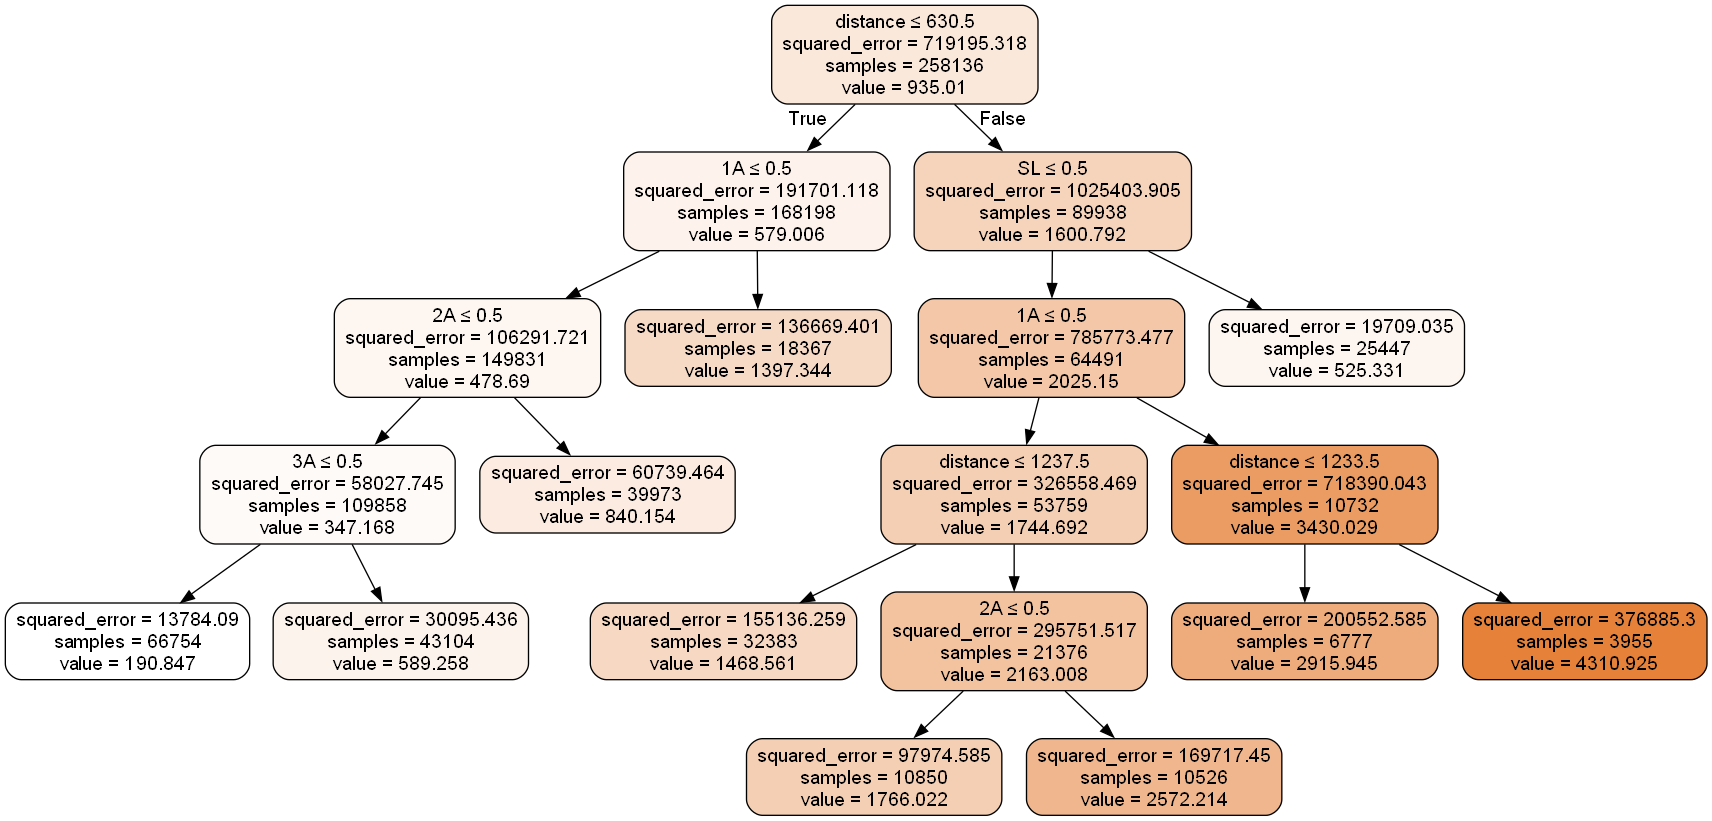

In [44]:
model = DecisionTreeRegressor(max_leaf_nodes=10)
model.fit(X_train, y_train)

dot_data = export_graphviz(model, out_file=None,
                          feature_names=dt_models[0].feature_names_in_,
                           filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("Plots/small_dt", format="png")
Image('Plots/small_dt.png')

In [60]:
accuracies_dt = {}

def get_accuracy(X_train, y_train):
    model = DecisionTreeRegressor(max_leaf_nodes=50, max_depth=10)
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [61]:
# under sampling

class_codes = ['1A', '2A', '3A', 'CC', 'SL', '2S']
mn = len(X_train)
for cc in class_codes:
    mn = min(mn, X_train[cc].sum())

X_balanced = pd.DataFrame(columns=X_train.columns)
for cc in class_codes:
    sampled = X_train[X_train[cc]].sample(mn)
    X_balanced = pd.concat([X_balanced, sampled])

X_balanced = X_balanced.sample(len(X_balanced))
y_balanced = y_train.loc[X_balanced.index]

accuracies_dt['under-sampling'] = get_accuracy(X_balanced, y_balanced)

C:\Users\bhavy\AppData\Local\Temp\ipykernel_22308\792809104.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_balanced = pd.concat([X_balanced, sampled])


In [62]:
# over sampling

class_codes = ['1A', '2A', '3A', 'CC', 'SL', '2S']
mx = 0
for cc in class_codes:
    mx = max(mx, X_train[cc].sum())

X_oversamp = pd.DataFrame(columns=X_train.columns)
for cc in class_codes:
    sampled = X_train[X_train[cc]].sample(mx, replace=True)
    X_oversamp = pd.concat([X_oversamp, sampled])

X_oversamp = X_oversamp.sample(len(X_oversamp))
y_oversamp = y.iloc[X_oversamp.index]

accuracies_dt['over-sampling'] = get_accuracy(X_oversamp, y_oversamp)

C:\Users\bhavy\AppData\Local\Temp\ipykernel_22308\35722586.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_oversamp = pd.concat([X_oversamp, sampled])


C:\Users\bhavy\AppData\Local\Temp\ipykernel_22308\692252892.py:10: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_balanced_price = pd.concat([y_balanced_price, y_sampled])


Text(0.5, 1.0, 'Histogram of prices to predict')

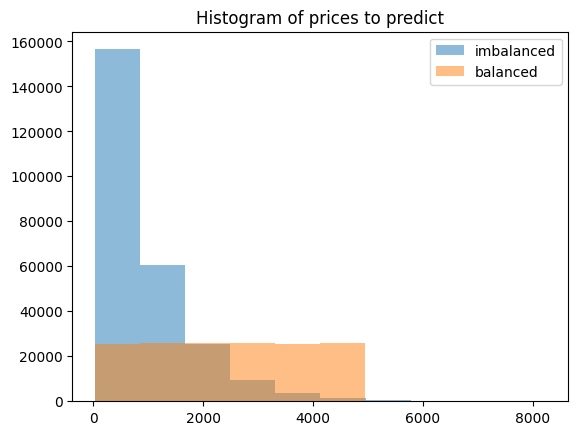

In [70]:
# sampling by price

counts, prices, _ = plt.hist(y_train, bins=10, alpha=.5, label='imbalanced')
n_samples = int(counts[2])

y_balanced_price = pd.Series()
for i in range(6):
    y_filt = y_train[(y_train>=prices[i]) & (y_train<prices[i+1])]
    y_sampled = y_filt.sample(n_samples, replace=True)
    y_balanced_price = pd.concat([y_balanced_price, y_sampled])

y_balanced_price = y_balanced_price.sample(len(y_balanced_price))
X_balanced_price = X_train.loc[y_balanced_price.index]
accuracies_dt['price-balanced'] = get_accuracy(X_balanced_price, y_balanced_price)

plt.hist(y_balanced_price, bins=6, alpha=.5, label='balanced')
plt.legend()
plt.title("Histogram of prices to predict")

In [77]:
accuracies_dt['no-fare-analysis, no-dist-dur'] = .4589
accuracies_dt['no-fare-analysis, precomp-dist-dur'] = .9392
accuracies_dt_series = pd.Series(accuracies_dt).sort_values()

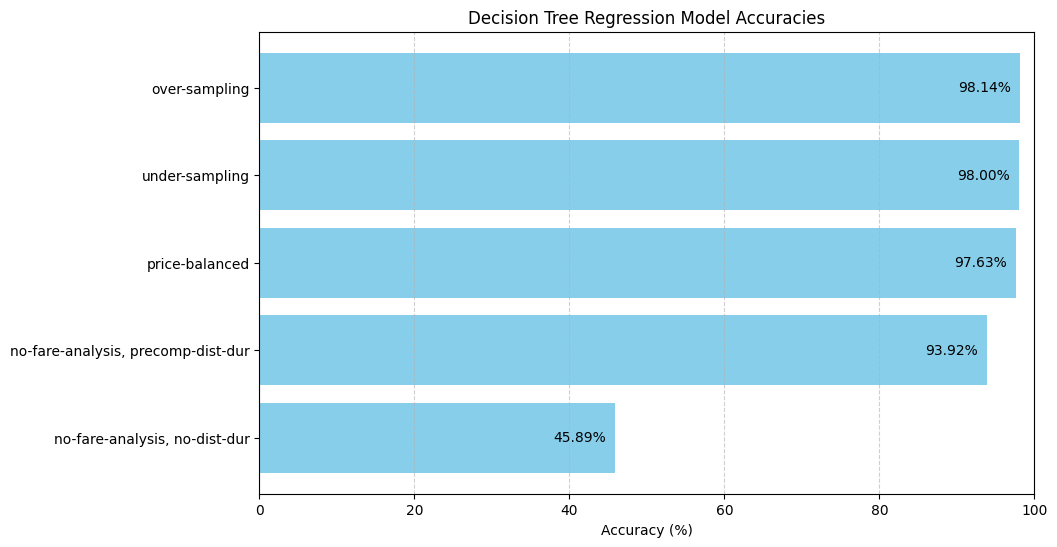

In [78]:
plt.figure(figsize=(10, 6))
bars = plt.barh(accuracies_dt_series.index, accuracies_dt_series*100, color='skyblue')
plt.xlabel('Accuracy (%)')
plt.title('Decision Tree Regression Model Accuracies')
plt.xlim(0, 100)  # Set the x-axis limits for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Display the accuracy values on the bars with a small offset
for bar, acc in zip(bars, accuracies_dt_series*100):
    plt.text(bar.get_width() - 8, bar.get_y() + bar.get_height()/2, f'{acc:.2f}%', color='black', va='center')
plt.savefig("Plots/conditions_on_DTR.png")